# Using pre-trained models for Texture Classification
In this lab, we will use pre-trained models for the same texture classification task. The dataset we will be using is available here: http://dx.doi.org/10.5281/zenodo.53169. 

![alt text](https://www.researchgate.net/profile/Jakob_Kather/publication/303998214/figure/fig7/AS:391073710002224@1470250646407/Representative-images-from-our-dataset-Here-the-first-10-images-of-every-tissue-class.png)

The above figure shows the 8 different classes of tissue we will be trying to identify. 

# Imports

Importing important modules, including tensorflow.

In [ ]:
# Basic operating system (os), numerical, and plotting functionality
import os
import time
import numpy as np
from matplotlib import pylab as plt

# scikit-learn data utilities
from sklearn.model_selection import train_test_split
from skimage import transform

# Color transformations
from skimage.color import rgb2lab

# scikit-learn performance metric utilities
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Import our neural network building tools
import tensorflow as tf

# Garbage collection (for saving RAM during training)
import gc

2021-07-19 05:24:01.089836: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-19 05:24:01.089890: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
# Set plotting preferences
import matplotlib
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

# InceptionV3 Model

In this notebook we will use the InceptionV3 model as the feature extractor. By downloading the model and its pretrained weights, we can leverage it for our own image classification problem. The model has been trained on the ImageNet image classification dataset. (For more details on this dataset see http://www.image-net.org/.)

<br>

Let's examine the InceptionV3 model. The model has the following specifications that are relevant for our task:
* Expected input size : 299x299 pixels
* Number of output classes : 1000

Our images are 150x150 pixels in size and come from only eight categories. In order to use this model for our classification task, we need to do the following:
* Resize images : Our input images can be resized to the appropriate dimensions. Alternatively, we can pad our images to the expected dimensions. Padding leads to additional choices - Do we pad with zeros, duplicate edge pixels or mirror the image across edges ?
* Change the prediction layer : Remove the existing prediction layer and add a new layer that can predict 8 classes.
* Train : Finally, we need to train the network on our data

# Retrieve and Load the Data

The following cells download the data from public Medlytics data repository and load those images and labels into memory.

In [ ]:
# Define the current directory and the directory where the files to download can
# be found
current_dir = os.getcwd()
remote_path = 'https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/'

# Define and build a directory to save this data in
data_dir = os.path.join(current_dir, 'crc_data')
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

# Move into the data directory and download all of the files
os.chdir(data_dir)
for ii in range(1, 6):
    basename = f'rgb0{ii}.npz'
    filename = os.path.join(remote_path, basename)

    # Check if the file has already been downloaded
    if not os.path.isfile(basename):
      cmd = f'wget {filename}'
      print(cmd)
      os.system(cmd)

# Return to the original directory
os.chdir(current_dir)

In [ ]:
# Define a function to load the data from the assumed download path
def load_images(colorspace='rgb'):
    """
    Loads the example data and applies transformation into requested colorspace

    Arguments
    ---------
    colorspace : str, optional, default: `rgb`
        The colorspace into which the images should be transformed. Accepted
        values include

        'rgb' : Standard red-green-blue color-space for digital images

        'gray' or 'grey': An arithmetic average of the (r, g, b) values

        'lab': The CIE L*a*b* colorspace
    
    Returns
    -------
    images : numpy.ndarray, shape (Nimg, Ny, Nx, Ncolor)
        The complete set of transformed images

    labels : numpy.ndarray, shape (Nimg)
        The classification labels associated with each entry in `images`

    label_to_str : dict
        A dictionary which converts the numerical classification value in
        `labels` into its string equivalent representation.
    """
    # Check that the colorspace argument is recognized
    colorspace_lower = colorspace.lower()
    if colorspace_lower not in ['rgb', 'gray', 'grey', 'lab']:
        raise ValueError(f'`colorspace` value of {colorspace} not recognized')

    # Load data, which is stored as a numpy archive file (.npz)
    filename = os.path.join(data_dir, 'rgb01.npz')
    print(f'loading {filename}')
    tmp = np.load(os.path.join(data_dir, 'rgb01.npz'), allow_pickle=True)

    # Parse the loaded data into images and labels
    # Initialize the images and labels variables using the first archive data
    images = tmp['rgb_data']
    if colorspace_lower == 'rgb':
        pass
    elif colorspace_lower in ['gray', 'grey']:
        images = np.mean(images, axis=-1)      # Average into grayscale
    elif colorspace_lower == 'lab':
        images = rgb2lab(images)               # Convert to CIE L*a*b*

    # Grab the initial array for the image labels
    labels = tmp['labels']
    
    # Grab the dictionary to convert numerical labels to their string equivalent
    label_to_str = tmp['label_str']
    label_to_str = label_to_str.tolist() # Convert label_to_str into a dict

    # Update the user on the number and size of images loaded
    print('Loaded images with shape {}'.format(images.shape))
    del tmp

    # Loop over each of the remaining archives and append the contained data
    for ii in range(2,6):
        # Build the full path to the archive and load it into memory
        filename = os.path.join(data_dir, f'rgb0{ii}.npz')
        print(f'loading {filename}')
        tmp = np.load(filename, allow_pickle=True)

        # Parse and append the data
        these_images = tmp['rgb_data']
        if colorspace_lower == 'rgb':
            pass
        elif (colorspace_lower == 'gray') or (colorspace_lower == 'grey'):
            these_images = np.mean(these_images, axis=-1) # Convert to grayscale
        elif colorspace_lower == 'lab':
            these_images = rgb2lab(these_images)          # Convert to CIEL*a*b*

        # Append the images and labels
        images = np.append(images, these_images, axis=0)
        labels = np.append(labels, tmp['labels'], axis=0)

        # Update the user on the number and size of images
        print('Loaded images with shape {}'.format(these_images.shape))
        del tmp

    # Force the image data to be floating point and print the data shape
    images = images.astype(np.float)
    print('Final image data shape: {}'.format(images.shape))
    print('Number of image labels: {}'.format(*labels.shape))

    return images, labels, label_to_str

In [ ]:
# Load images and labels into memory and count the number of classes
images_full_res, labels, label_to_str = load_images()
num_classes = np.unique(labels).size

loading /work/Week3Public/03_TransferLearning/crc_data/rgb01.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Week3Public/03_TransferLearning/crc_data/rgb02.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Week3Public/03_TransferLearning/crc_data/rgb03.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Week3Public/03_TransferLearning/crc_data/rgb04.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Week3Public/03_TransferLearning/crc_data/rgb05.npz
Loaded images with shape (1000, 150, 150, 3)
Final image data shape: (5000, 150, 150, 3)
Number of image labels: 5000


# Pre-process the Images

Apply the usual pre-processing steps to this image data

## Resize the Images

In [ ]:
# This boolean can be switched to false if you do not want to resize the images
resize_images_bool = True

# Specify a new shape to use for the resized images
# NOTE: For the InceptionV3 model, we must use a size of at least (75, 75).
# Other models may allow smaller input images.
original_shape = images_full_res.shape
new_shape = list(original_shape)
new_shape[1:3] = (299, 299)

# Compute if we are downsampling (in which case we need anti-aliasing)
scaling_ratio = np.array(new_shape[1:3])/np.array(original_shape[1:3])
anti_alias = np.any(scaling_ratio < 1)

# If resizing is requested, then run the resizing transformation
if resize_images_bool:
    # Grab the original shape of the images
    num_images = images_full_res.shape[0]

    # Initialize an array for storing the resized images
    images = np.zeros(new_shape, dtype=np.float16)

    # Loop over each image in the data and perform a resizing operation
    for img_num, img_data in enumerate(images_full_res):
        # Update the user on progress
        if np.mod(img_num, 1000) == 0:
            print(f'Processing image number {img_num}')

        # Process the image and force it to be a 16-bit float
        processed_img = transform.resize(img_data, new_shape[1:],
                                         anti_aliasing=anti_alias)
        images[img_num] = processed_img.astype(np.float16)

# If no resizing requested, then just rename that data
else:
    images = images_full_res

# Remove the full-resolution versions from memory (just clogging things up)
del images_full_res

print('Done!')

Processing image number 0
Processing image number 1000
Processing image number 2000
Processing image number 3000
Processing image number 4000
Done!


## Normalize the Images

The model we will be adpopting uses batch normalization, which suggests that we should scale the images to the range $\left[-1, +1\right]$.

In [ ]:
# Scale image values to the proper data range (if it hasn't been done already)
# Note: Think *very* carefully about what normalizaiton needs to be applied. In
# this example we originally constructed, the image data was in the range
# [0, 255], but you may try some different datasets and need to modify this
# normalization cell.
# images = images.astype(np.float16)/127.5 - 1
images = images.astype(np.float16)/255.0

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

## Include an Axis for Color Channels
In the case where we are operating on grayscale data, there should be an axis at the end of the array of length 1 to match up with TensorFlow expectations. Otherwise, you may get an error about not having the right number of dimensions for input data.

In [ ]:
# Take note of number of color channels in the loaded image add a last axis to 
# images ndarray if array dimension is only 3 (as is the case with grayscale images)
if images.ndim == 3:
    # If image is grayscale, then we add a last axis (of len 1) for channel
    n_channels = 1
    images = images[:, : , :, np.newaxis]
    print('\nlast dimension added to images ndarray to account for channel')
    print(f'new images.shape: {images.shape}')
else:
    #if image is not grayscale, last dimension of image already corresponds to channel
    n_channels = images.shape[-1]

## Split the Image and Label Data


In [ ]:
# Split data into train and test sets
tmp = train_test_split(images, labels, test_size=.2)
train_images, test_images, train_labels, test_labels = tmp

# Convert 'labels' (1D array of integers) to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# Print sizes of train/test sets
print(f'train_images.shape: {train_images.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_images.shape: {test_images.shape}')
print(f'test_labels.shape: {test_labels.shape}')

# Print the one-hot encoded labels as a sanity check
print('one-hot encoded labels:')
print(train_labels)

# Get rid of the duplicate copies of the data
del images, labels

train_images.shape: (4000, 299, 299, 3)
train_labels.shape: (4000, 8)
test_images.shape: (1000, 299, 299, 3)
test_labels.shape: (1000, 8)
one-hot encoded labels:
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


# Use Transfer Learning to Build the CNN

Load a pre-trained version of the InceptionV3 model. The weights in this model were learned from the (*very* large ImageNet dataset).

## Load the Pre-Trained CNN Architecture and Weights

In [ ]:
print('Loading Pre-Trained Model')
# Load the base, pre-trained model
#
# -- Arguments --
# input_shape : simply grab the (nrows, ncols, nchannels) part of the image data
# include_top : do *not* download the final, classification layers of the model
# weights : use the weights learned from the ImageNet dataset
#
base_model = tf.keras.applications.InceptionV3(input_shape=train_images.shape[1:],
                                               include_top=False,
                                               weights='imagenet')

Loading InceptionV3


Let's go ahead and take a look at the architecture of the base model... but be warned... it is *very* deep.

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week3/leo_deeper_cnn.jpg" width="500">

In [ ]:
# Print the model summary to screen
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Freeze the Convolutional Base

The following cell forces the convolutional part of the CNN to remain "frozen" so that none of the filter weights are changed during the training process. This approach assumes that the weights learned during the pre-training on the ImageNet dataset are sufficiently useful for our new application, so we will leave them as they are. In practice, it seems that freezing layers increase the training speed while have little impact on accuracy.

It is also possible to freeze specific layers within the CNN by setting `layer.trainable = False`, but since the InceptionV3 model has so many layers, we will simply use a single command to freeze *all* of the layers in the base model. You can read more about Freezing Layers here: https://keras.io/guides/transfer_learning/#freezing-layers-understanding-the-trainable-attribute.

Why would we need these layers in the first place? Well, sometimes we need a very deep NN (such as this pretrained model with its useful weights), but we don't have enough time or data to train it.

In [ ]:
# Freeze the entire base model
base_model.trainable = False

In the following cell, we define some functions that may be useful for experimenting with unfreezing specific layers of the model. In general, with a smaller dataset, it is not advised that you make *all* layers trainable. Instead, you should leave at least some of the layers in the pre-trained model frozen.

In [ ]:
# Define some functions for experimenting with unfreezing layers
def unfreeze_layers(model, top_n_layers):
    """Makes the top layers of the `base_model` trainable (except batch norm)"""
    # We unfreeze the top layers while leaving BatchNorm layers frozen
    for layer in model.layers[-top_n_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

def freeze_layers(model, top_n_layers):
    """Makes the top layers of the `base_model` untrainable"""
    # We unfreeze the top layers while leaving BatchNorm layers frozen
    for layer in model.layers[-top_n_layers:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

In [ ]:
### OPTIONAL: Experiment with unfreezing some layers in the pretrained model
# n_layers = 20
# unfreeze_layers(model, n_layers)

## Add a Global Average Pooling Layer

By adding a global pooling layer, we can guarantee that the output from the base model will be translated into a single 2048 element vector for each input image, even if the size of the input image is increased! This is convenient because it allows us to play with different image sizes without needing to re-design our final CNN model.

In [ ]:
# Create a global pooling layer to be added into the model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

## Build a Prediction Layer

As a final step in the transfer learning process, we need to add a layer which will convert those 2048 element feature vectors into predicted classifications. This can be accomplished by a single dense layer with an output size equal to the number of classes (which we have conveniently stored in a variable named `num_classes`).

In [ ]:
# let's add a fully-connected layer
prediction_layer1 = tf.keras.layers.Dense(64, activation='relu')

# Add the final classification layer
prediction_layer2 = tf.keras.layers.Dense(num_classes, activation='softmax')

# # Build a single fully-connected layer to perform the final classifications
# prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

## Combine Components into Final Model

Now, we can combine the feature-extracting "base_model," the global pooling average layer, and the fully-connected classification layer to produce a single, final model.

In [ ]:
# Build the final model as a sequence:
# input --> feature extractor --> global pooling --> classifier --> predictions
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer1,
    prediction_layer2
])

## Compile and Train the Model

Specify the loss function and training algorithm to be used, then compile the model.

In [ ]:
# Specify the loss function to use
loss_func = tf.keras.losses.categorical_crossentropy

# Use the RMSprop learning algorithm to optimize the network weights
base_learning_rate = 0.0001
opt = tf.keras.optimizers.RMSprop(lr=base_learning_rate)

# Compile the model using the specified loss function and potimizer
model.compile(loss=loss_func, optimizer=opt, metrics=['accuracy'])

Train the model on the new, histological, data

In [ ]:
# Convert all of our training and validation ('test') data to TensorFlow data
# This prevents the training algorithm from needing to make a *copy* of your
# numpy arrays, which would EAT UP SOO MUCH RAM!
#
# It also accelerates training a bit because there is no data-conversion step
train_images_tf = tf.constant(train_images, dtype=tf.float16)
test_images_tf = tf.constant(test_images)
del train_images, test_images

train_labels_tf = tf.constant(train_labels, dtype=tf.float16)
test_labels_tf = tf.constant(test_labels)
del train_labels, test_labels

In [ ]:
# This function is called after each epoch
# (It will ensure that your training process does not consume all available RAM)
class garbage_collect_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

# Time how long it takes the model to train for these epochs
start_time = time.time()

# Perform the training method
history = model.fit(train_images_tf,
                    train_labels_tf,
                    batch_size=32,
                    epochs= 12,
                    verbose=True,
                    validation_data=(test_images_tf, test_labels_tf),
                    callbacks = [garbage_collect_callback()])

stop_time = time.time()
print("--- %s seconds ---" % (stop_time - start_time))

Epoch 1/12
125/125 [==============================] - 45s 356ms/step - loss: 1.1845 - accuracy: 0.6837 - val_loss: 0.7474 - val_accuracy: 0.8140
Epoch 2/12
125/125 [==============================] - 42s 339ms/step - loss: 0.5749 - accuracy: 0.8450 - val_loss: 0.4865 - val_accuracy: 0.8540
Epoch 3/12
125/125 [==============================] - 42s 339ms/step - loss: 0.4163 - accuracy: 0.8748 - val_loss: 0.4095 - val_accuracy: 0.8680
Epoch 4/12
125/125 [==============================] - 42s 339ms/step - loss: 0.3457 - accuracy: 0.8970 - val_loss: 0.3544 - val_accuracy: 0.8800
Epoch 5/12
125/125 [==============================] - 42s 340ms/step - loss: 0.3051 - accuracy: 0.9028 - val_loss: 0.3288 - val_accuracy: 0.8890
Epoch 6/12
125/125 [==============================] - 42s 340ms/step - loss: 0.2739 - accuracy: 0.9145 - val_loss: 0.3142 - val_accuracy: 0.8890
Epoch 7/12
125/125 [==============================] - 43s 340ms/step - loss: 0.2532 - accuracy: 0.9202 - val_loss: 0.3057 - val_ac

### Example Results for Different Input Image Sizes

After running some experiment swith different input image sizes, we found the following results.


| Resizing    | Validation Accuracy  |
| ----------- | -------------------- |
|  75 pixels  | $78.7\%$             |
| 150 pixels  | $84.7\%$             |
| 250 pixels  | $88.2\%$             |
| 299 pixels  | $90.4\%$             |


## Examine the Training History

Let's plot the progress of the training procedure to see if we started to overfit at any point. 

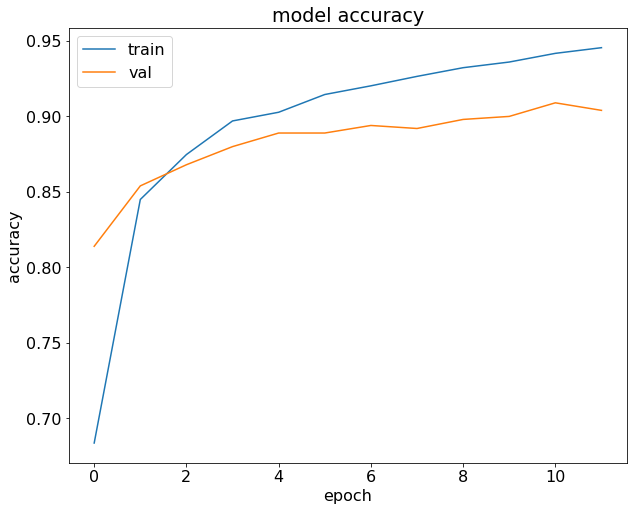

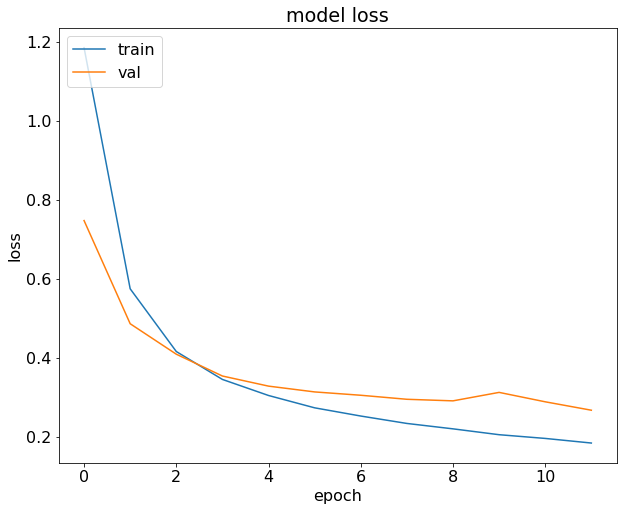

In [ ]:
# Plot model train/validation accuracy and model train/validation loss
# Summarize history for accuracy
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Predict Classes for the Test Images
Use trained model to predict classes of test and then plot some example predicted classifications.

In [ ]:
# Predict class of test each test
predictions = model.predict(test_images_tf, verbose=True)

# Convert the predictions and true labels into category numbers
test_true_labels = test_labels_tf.numpy().argmax(axis=1)
test_pred_labels = predictions.argmax(axis=1)

32/32 [==============================] - 8s 257ms/step


(1000, 8)
(1000,)
5


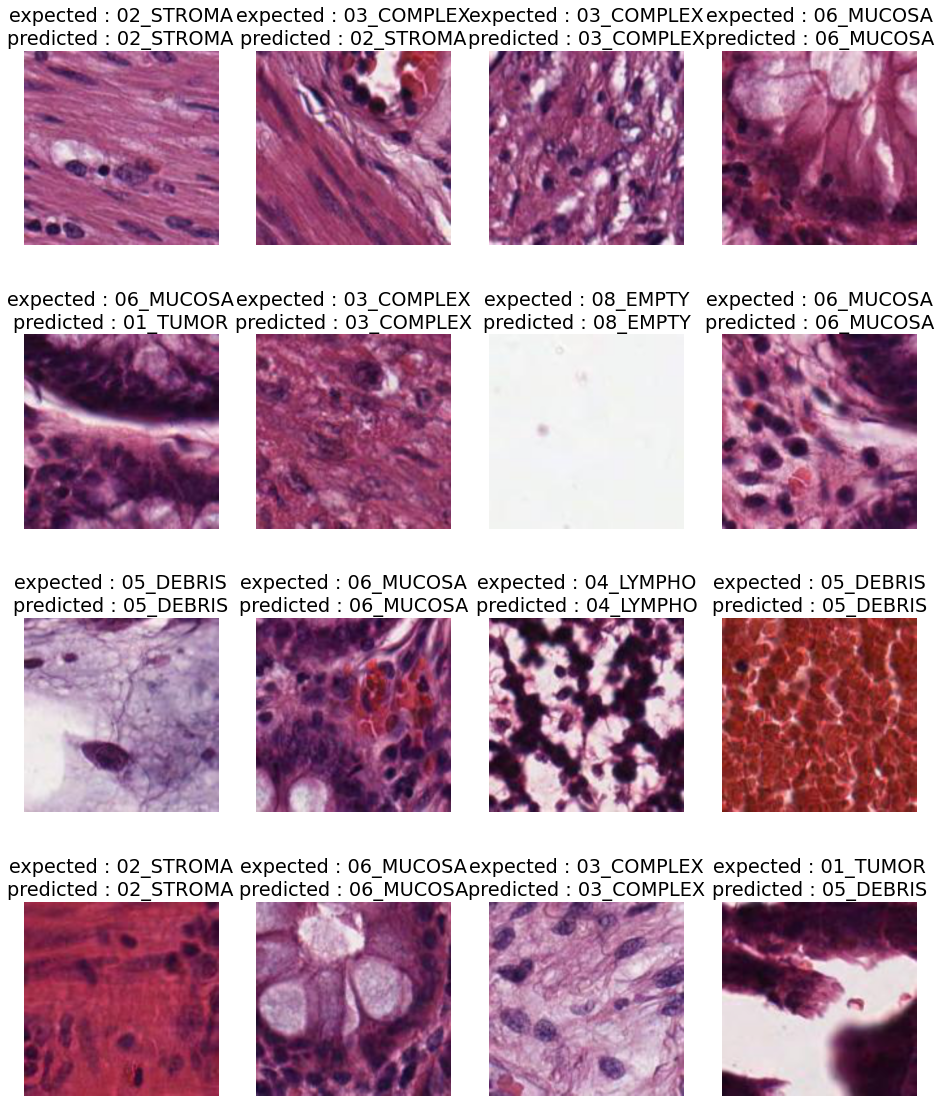

In [ ]:
# Plot a set of test images, along with predicted labels and true labels
plt.figure(figsize=(16,20))
for ii in range(0, 16):
    # Activate subplot and display image
    plt.subplot(4,4,ii+1)
    plt.imshow(test_images_tf[ii+100,:,:,:].numpy().astype(np.float))

    # Turn off axes
    plt.axis('off')

    # Add annotaiton
    plt.title('expected : ' + label_to_str[test_true_labels[ii+100]]
              + '\npredicted : ' + label_to_str[test_pred_labels[ii+100]])
plt.show()

To conclude this section. Let's Look at the final computed accuracy and confusion matrix for the validation set.

In [ ]:
# Compute the model accuracy and print it to the user
acc = accuracy_score(test_true_labels, test_pred_labels)
print(f'Model Accuracy: {acc:.2%}')

Model Accuracy: 90.40%


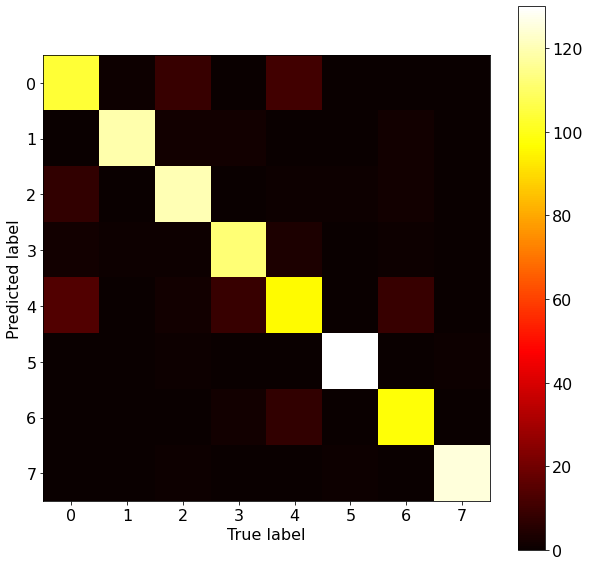

In [ ]:
# Generate the confusion matrix using these labels
conf_mat = confusion_matrix(test_true_labels, test_pred_labels)

# Generate a new figure
plt.figure(figsize=(10,10))

# Display the confusion matrix
plt.imshow(conf_mat, cmap='hot', interpolation='nearest')

# Add some anotation for the plot
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

# Conclusions

* The purpose of transfer learning is to adapt existing trained neural networks to different classification problems
* Transfer learning allows us to train a neural network classifier much faster and with less data
* By 'freezing' layers of the existing trained network, we can ensure training only takes place within a smaller subset of network layers -- this ability affords us the benefits of a large well-designed expressive network without requiring creation from scratch.

## Additional Experiments to Run

* Try un-freezing some or all of the "base_model" layers.

* Try comparing te un-frozen version of the model across a variety of input image sizes.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=37179657-af6c-4b10-ba18-5b7441fab104' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>